## Data Cleaning

In [1]:
# Load the data

import pandas as pd

def load_data(path):
    return pd.read_csv(path, sep=";", header=0, names=["athlete_id", "gender", "timestamp", "distance", "elapsed_time", "elev_gain", "bpm"])

raw_data = load_data("./data.csv")

# Remove rows with 0 distance as these are not actually activities
data = raw_data[raw_data["distance"] != 0.0]
data = data.drop(columns=["athlete_id"])
data["timestamp"] = data.apply(lambda x: x['timestamp'][11:13], axis = 1)
data = data.reset_index(drop=True)

data.head()

,gender,timestamp,distance,elapsed_time,elev_gain,bpm
0,M,09,2965.8,812,17.4,150.3
1,M,19,10020.8,3290,52.2,160.8
2,M,19,12132.2,4027,249.0,148.9
3,M,19,11631.5,4442,194.0,136.2
4,M,19,11708.1,4022,250.7,146.0


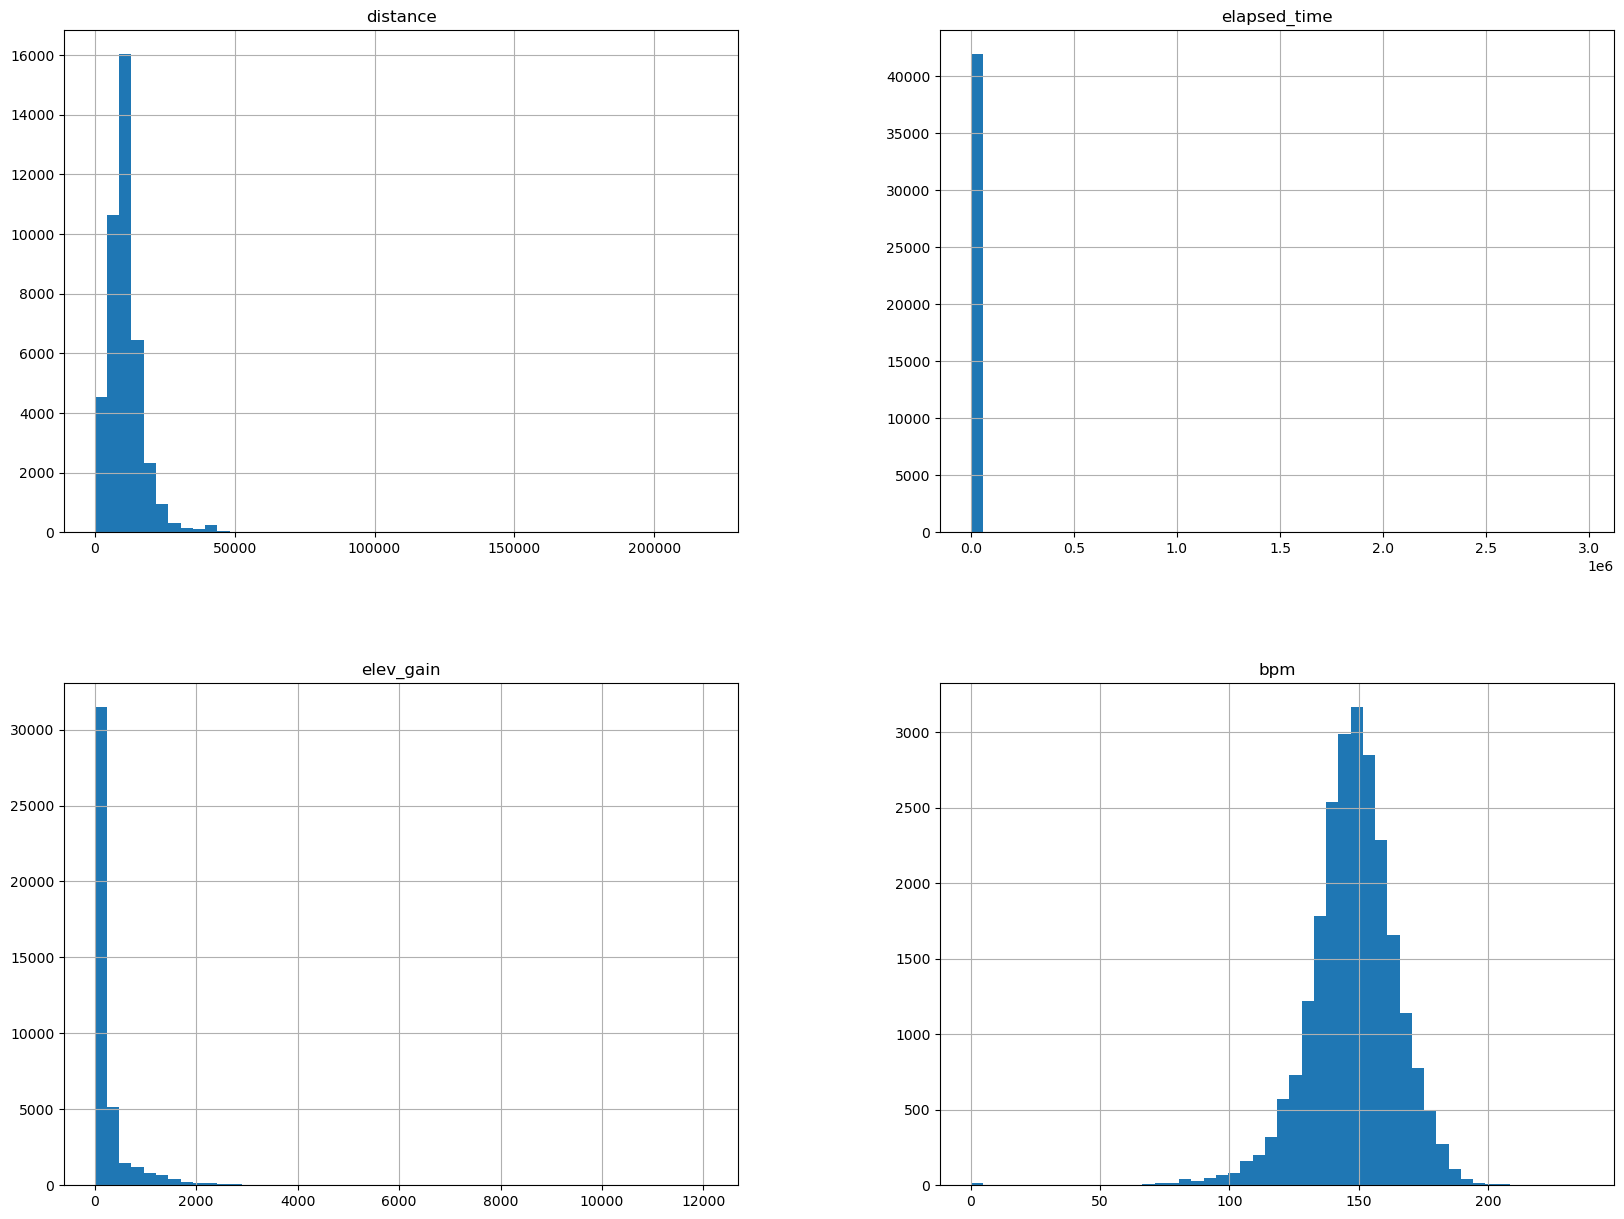

In [2]:
# Vizualize data

%matplotlib inline
import matplotlib.pyplot as plt
data.hist(bins=50, figsize=(20,15))
plt.show()

<Axes: >

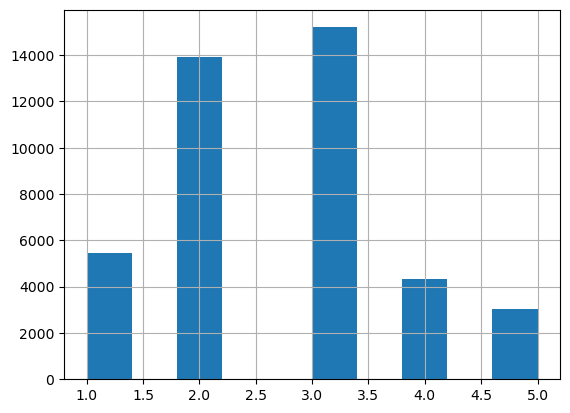

In [3]:
# Perform stratified sampling on the distance attribute, as this is an important factor in predicting finishing time

import numpy as np

data["distance_cat"] = pd.cut(data["distance"], 
                                bins = [0., 5000., 10000., 15000., 20000., np.inf],
                                labels=[1, 2, 3, 4, 5])

data["distance_cat"].hist()

In [4]:
# Split data into training and test sets

from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(data, data["distance_cat"]):
    train_set = data.loc[train_index]
    test_set = data.loc[test_index]

In [5]:
# Drop distance_cat attribute

for set_ in (train_set, test_set):
    set_.drop("distance_cat", axis=1, inplace=True)

In [6]:
train_set.head()

,gender,timestamp,distance,elapsed_time,elev_gain,bpm
37757,M,11,12234.0,3711,132.0,160.8
19791,M,08,3917.0,1302,87.9,152.9
14060,F,06,5620.0,1846,16.0,NaN
32891,M,06,12485.1,4176,53.0,146.8
36253,M,15,14516.6,4147,123.2,NaN


## Data Exploration

In [9]:
explore = train_set.copy()

In [11]:
# Correlation between variables and time

corr_matrix = explore.corr(numeric_only=True)
corr_matrix["elapsed_time"].sort_values(ascending=False)

elapsed_time    1.000000
distance        0.499287
elev_gain       0.468611
bpm            -0.017847
Name: elapsed_time, dtype: float64

<Axes: xlabel='elapsed_time', ylabel='distance'>

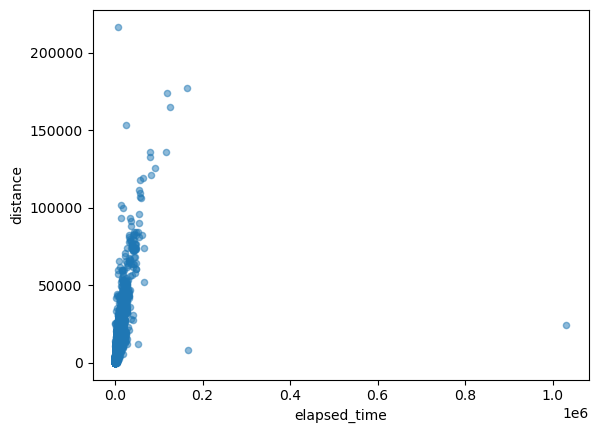

In [12]:
# Vizualize high correlations

explore.plot(kind="scatter", x="elapsed_time", y="distance", alpha=0.5)

<Axes: xlabel='elapsed_time', ylabel='elev_gain'>

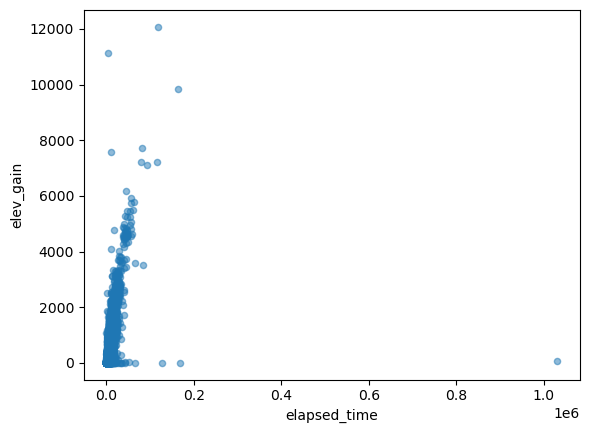

In [13]:
explore.plot(kind="scatter", x="elapsed_time", y="elev_gain", alpha=0.5)

## Data Preparation

In [14]:
# Replace all missing gender values with M, as this is the more common value in the dataset

explore["gender"] = explore["gender"].fillna("M")

# Drop rows that are missing bpm

explore = explore.dropna(subset=["bpm"])
explore.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18989 entries, 37757 to 10195
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   gender        18989 non-null  object 
 1   timestamp     18989 non-null  object 
 2   distance      18989 non-null  float64
 3   elapsed_time  18989 non-null  int64  
 4   elev_gain     18989 non-null  float64
 5   bpm           18989 non-null  float64
dtypes: float64(3), int64(1), object(2)
memory usage: 1.0+ MB


In [15]:
# Transform gender attribute to categorical (M is 0, F is 1)

explore.loc[explore['gender'] == 'M', 'gender'] = 0
explore.loc[explore['gender'] == 'F', 'gender'] = 1

explore.head()

,gender,timestamp,distance,elapsed_time,elev_gain,bpm
37757,0,11,12234.0,3711,132.0,160.8
19791,0,08,3917.0,1302,87.9,152.9
32891,0,06,12485.1,4176,53.0,146.8
30653,0,16,8086.1,2508,47.0,137.9
15281,0,03,1743.8,602,8.0,120.5


In [16]:
# Map bpm to heart rate zones

def map_to_zone(bpm):
    if bpm <= 104: 
        return 1
    elif bpm > 104 and bpm <= 121:
        return 2
    elif bpm > 121 and bpm <= 139:
        return 3
    elif bpm > 139 and bpm <= 156:
        return 4
    else:
        return 5 

explore["bpm"] = explore["bpm"].apply(map_to_zone)
explore.head()

C:\Users\quiri\AppData\Local\Temp\ipykernel_15076\1049792253.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  explore["bpm"] = explore["bpm"].apply(map_to_zone)


,gender,timestamp,distance,elapsed_time,elev_gain,bpm
37757,0,11,12234.0,3711,132.0,5
19791,0,08,3917.0,1302,87.9,4
32891,0,06,12485.1,4176,53.0,4
30653,0,16,8086.1,2508,47.0,3
15281,0,03,1743.8,602,8.0,2


In [17]:
# Map timestamp to time of day
# 0: 12AM-3:59AM, 1: 4AM-7:59AM, 2: 8AM-11:59AM, 3: 12PM-3:59PM, 4: 4PM-7:59PM, 5: 8PM-11:59PM

explore["timestamp"] = explore["timestamp"].astype("int")
explore["time_of_day"] = (explore['timestamp'] % 24) // 4 
explore = explore.drop(columns=["timestamp"])

C:\Users\quiri\AppData\Local\Temp\ipykernel_15076\925342773.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  explore["timestamp"] = explore["timestamp"].astype("int")
C:\Users\quiri\AppData\Local\Temp\ipykernel_15076\925342773.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  explore["time_of_day"] = (explore['timestamp'] % 24) // 4


In [18]:
# Drop labels for training set

prepared = explore.drop("elapsed_time", axis=1) 
labels = explore["elapsed_time"].copy()
prepared

,gender,distance,elev_gain,bpm,time_of_day
37757,0,12234.0,132.0,5,2
19791,0,3917.0,87.9,4,2
32891,0,12485.1,53.0,4,1
30653,0,8086.1,47.0,3,4
15281,0,1743.8,8.0,2,0
...,...,...,...,...,...
14872,0,5852.0,44.1,5,3
22190,0,11076.1,403.0,4,1
13836,1,14602.0,19.0,4,2
34805,0,11003.2,0.0,3,3


## Feature Scaling

In [19]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().set_output(transform="pandas")
prepared = scaler.fit_transform(prepared)
prepared

,gender,distance,elev_gain,bpm,time_of_day
37757,-0.502237,0.176543,-0.231912,1.159303,-0.512247
19791,-0.502237,-1.074504,-0.337334,0.033497,-0.512247
32891,-0.502237,0.214313,-0.420763,0.033497,-1.365348
30653,-0.502237,-0.447386,-0.435106,-1.092308,1.193955
15281,-0.502237,-1.401398,-0.528336,-2.218114,-2.218449
...,...,...,...,...,...
14872,-0.502237,-0.783441,-0.442038,1.159303,0.340854
22190,-0.502237,0.002371,0.415918,0.033497,-1.365348
13836,1.991091,0.532738,-0.502040,0.033497,-0.512247
34805,-0.502237,-0.008595,-0.547460,-1.092308,0.340854


## Testing Models

In [20]:
# Time to use Elastic Net (for regularization)
# This is because only a few features are useful

from sklearn.linear_model import ElasticNet
model = ElasticNet(alpha=0.1, l1_ratio=0.5)
model.fit(prepared, labels)

ElasticNet(alpha=0.1)

In [21]:
from sklearn.metrics import mean_squared_error

predictions = model.predict(prepared)
mse = mean_squared_error(labels, predictions)
rmse = np.sqrt(mse)
rmse

1108.3398414294336

In [22]:
# Tune hyperparamters using grid search

from sklearn.model_selection import GridSearchCV

grid = dict()
grid['alpha'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0]
grid['l1_ratio'] = np.arange(0, 1, 0.01)
search = GridSearchCV(model, grid, scoring='neg_mean_squared_error', cv=5)
results = search.fit(prepared, labels)
print('MAE: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)

c:\Users\quiri\anaconda3\envs\timepredictor\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.843e+09, tolerance: 1.797e+07 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
c:\Users\quiri\anaconda3\envs\timepredictor\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.679e+09, tolerance: 1.760e+07 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of th

MAE: -1234232.113
Config: {'alpha': 0.1, 'l1_ratio': 0.93}


In [23]:
modelnew = ElasticNet(alpha=0.1, l1_ratio=0.93)
modelnew.fit(prepared, labels)
predictionsnew = modelnew.predict(prepared)
msenew = mean_squared_error(labels, predictionsnew)
rmsenew = np.sqrt(msenew)
rmsenew

1103.5648086981332

In [24]:
# Testing SVR

from sklearn.svm import SVR

svm_reg = SVR(kernel='rbf')
svm_reg.fit(prepared, labels)
svr_predicitons = svm_reg.predict(prepared)
svr_mse = mean_squared_error(labels, svr_predicitons)
svr_rmse = np.sqrt(svr_mse)
svr_rmse


3135.1274330721585

## Elastic Net Chosen

In [25]:
# Evaluate elastic net on test set

final_model = modelnew
test = test_set.copy()

test["gender"] = test["gender"].fillna("M")
test = test.dropna(subset=["bpm"])
test.loc[test['gender'] == 'M', 'gender'] = 0
test.loc[test['gender'] == 'F', 'gender'] = 1
test["bpm"] = test["bpm"].apply(map_to_zone)
test["timestamp"] = test["timestamp"].astype("int")
test["time_of_day"] = (test['timestamp'] % 24) // 4 
test = test.drop(columns=["timestamp"])

x_test = test.drop('elapsed_time', axis=1)
x_test = scaler.transform(x_test)
y_test = test['elapsed_time'].copy()

final_predictions = final_model.predict(x_test)
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

965.3354732672134

In [27]:
predict_data = pd.DataFrame(np.array([[1,4828,0,1,2]]), columns = ['gender','distance','elev_gain', 'bpm','time_of_day'])
make_predict = scaler.transform(predict_data)
make_predict

,gender,distance,elev_gain,bpm,time_of_day
0,1.991091,-0.937471,-0.54746,-3.34392,-0.512247


In [28]:
final_model.predict(make_predict)

array([2841.65905707])